## 1. Install necessary packages for use.

In [1]:
# !pip install pandas_datareader
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn
# !pip install statsmodels
# !pip install openpyxl
# !pip install xlrd

from pandas_datareader import data as pdr #read data from yahoo finance api
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime 
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_acf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics

from random import gauss #create gaussian white noise
from random import seed
from pandas import Series 
import requests #Make API requests
import json #Perform JSON related operations.

Read data from the data folder. If the relative path is different from the one below, please upate as required.

In [2]:
ful = pd.read_csv('data/foodDemand_train/fulfilment_center_info.csv')
meal = pd.read_csv('data/foodDemand_train/meal_info.csv')
df = pd.read_csv('data/foodDemand_train/train.csv')

In [3]:
ful.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [4]:
meal.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [5]:
df.describe()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
count,4.565480e+05,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000
mean,1.250096e+06,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.10920,261.872760
std,1.443548e+05,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.31189,395.922798
min,1.000000e+06,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.00000,13.000000
25%,1.124999e+06,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.00000,54.000000
50%,1.250184e+06,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.00000,136.000000
75%,1.375140e+06,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.00000,324.000000
max,1.499999e+06,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.00000,24299.000000


In [6]:
ful.region_code.nunique()

8

In [7]:
ful.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


Combine various data sources into a single dataframe for easier processing.

In [8]:
df = df.merge(meal, on='meal_id')

In [9]:
df = df.merge(ful, on='center_id')

In [10]:
df.isna().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
category                 0
cuisine                  0
city_code                0
region_code              0
center_type              0
op_area                  0
dtype: int64

## 2. Exploratory Data Analysis

<Figure size 1500x1500 with 0 Axes>

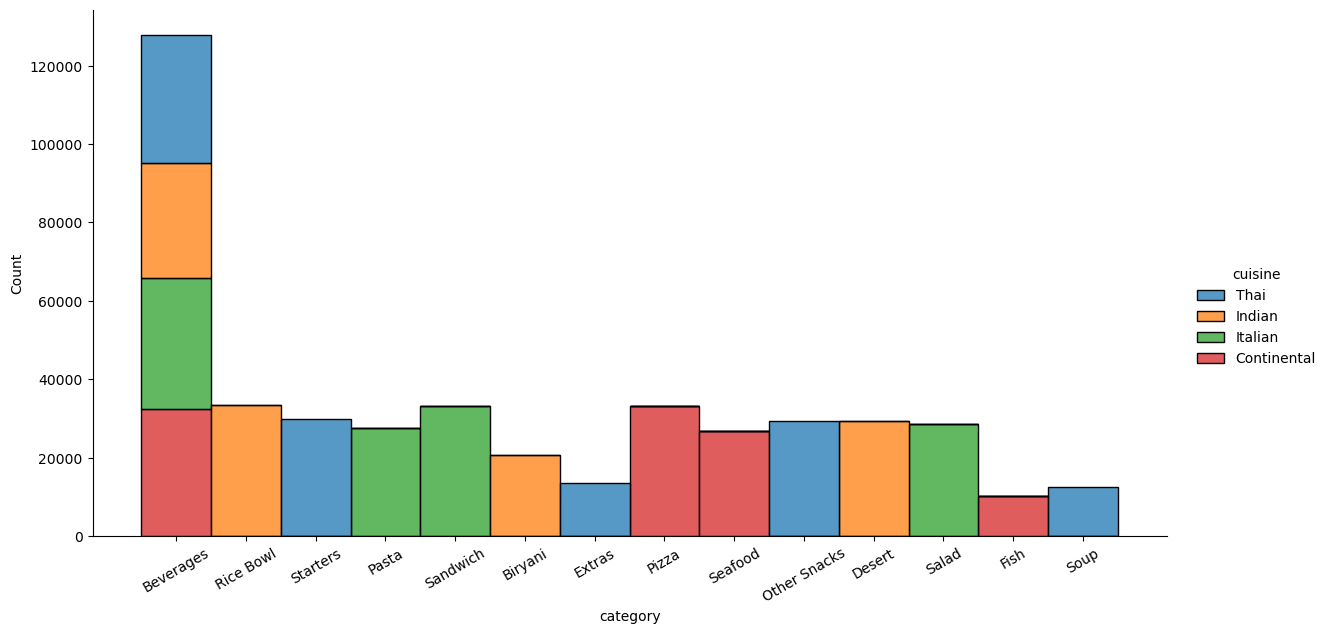

In [11]:
fig = plt.figure(figsize=(15,15))

g = sns.displot(data=df, x='category', hue = 'cuisine',height = 6, aspect = 2, multiple = 'stack')
g.set_xticklabels(rotation=30)
plt.show()

We see from the above that beverages were the most ordered product across different cusines. Some cusines such as Continental have specific foods such as seafood, Piazza and Fish.

In [12]:
df.groupby(['category'])['base_price'].mean()

category
Beverages       226.854609
Biryani         460.962293
Desert          466.559037
Extras          204.934888
Fish            596.939319
Other Snacks    273.385964
Pasta           428.045511
Pizza           643.765222
Rice Bowl       339.386778
Salad           300.579144
Sandwich        305.233585
Seafood         665.176243
Soup            231.415428
Starters        284.118421
Name: base_price, dtype: float64

Examining a single meal the number of orders per week. We don't see any seasonality but there is an increasing trend.

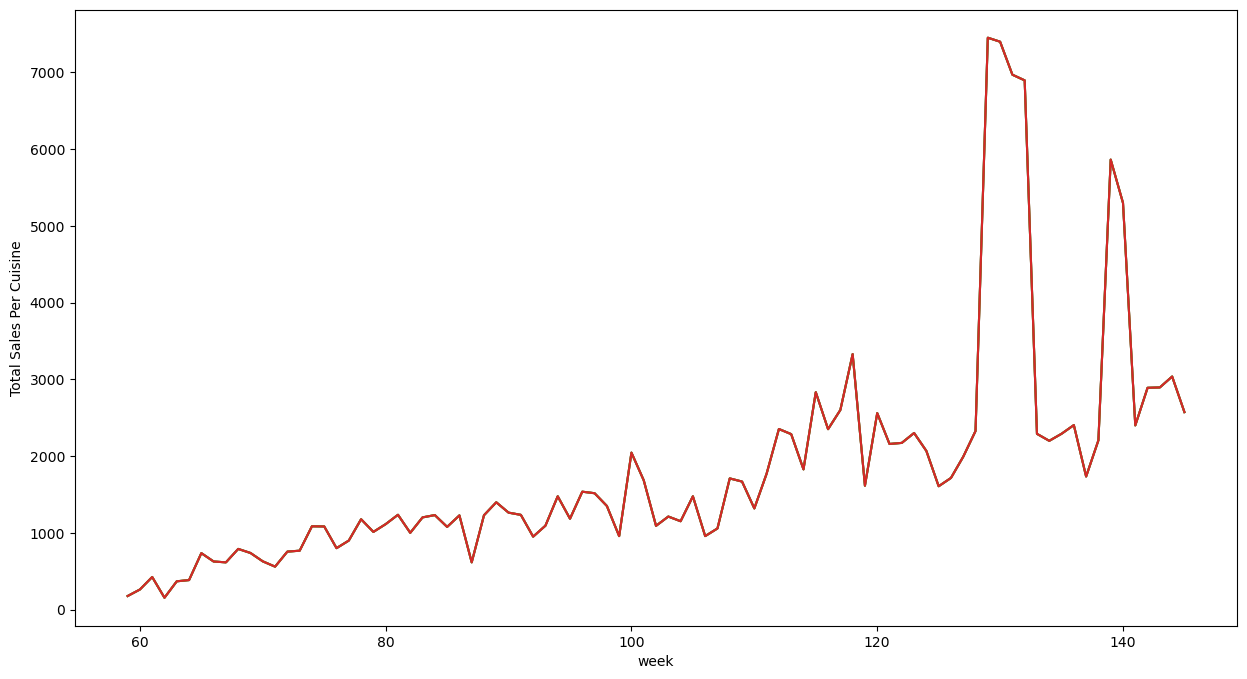

In [13]:
plt.figure(figsize=(15,8))
for typ in list(df['cuisine'].unique()):
    weekwise = df[df['meal_id'] == 2104].groupby('week').num_orders.sum()
    weekwise.plot()
plt.ylabel('Total Sales Per Cuisine')
plt.show()

Across different cusines as well we don't see a specific seasonality.

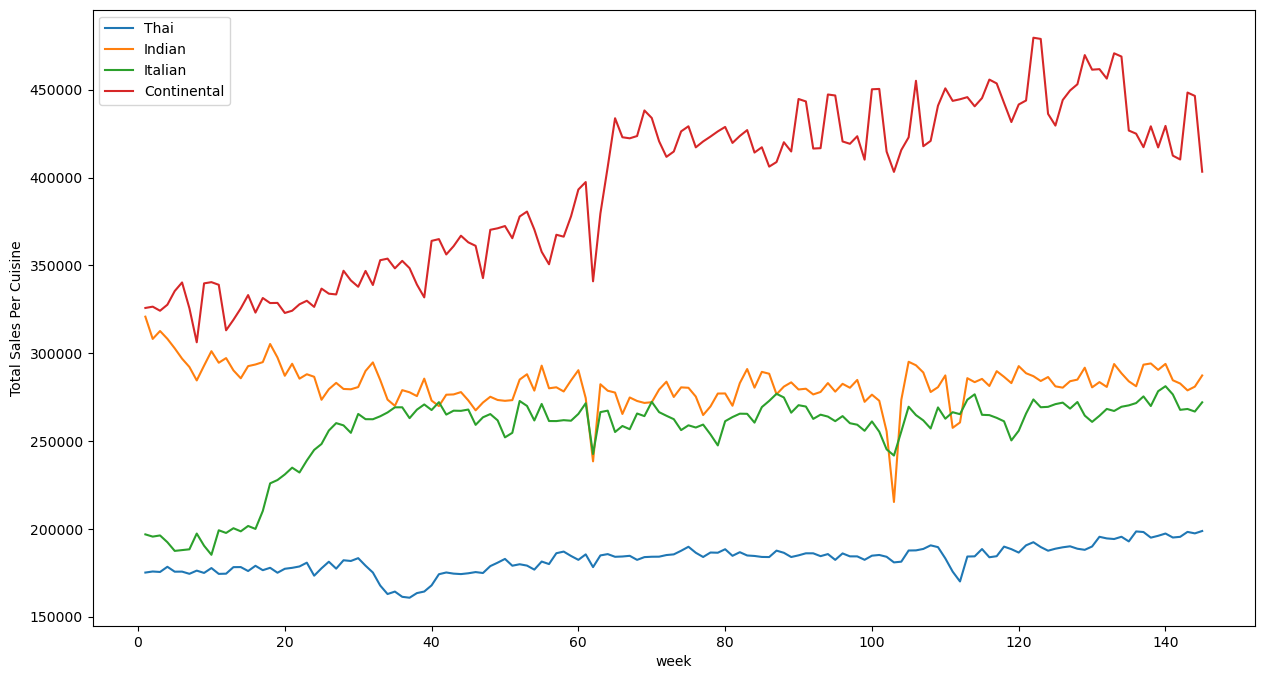

In [14]:
plt.figure(figsize=(15,8))
for typ in list(df['cuisine'].unique()):
    weekwise = df[df['cuisine'] == typ].groupby('week').base_price.sum()
    weekwise.plot()
plt.ylabel('Total Sales Per Cuisine')
plt.legend(list(df['cuisine'].unique()))
plt.show()

In [15]:
thai_week = df[df['cuisine'] == 'Thai'].groupby('week').base_price.sum()
indian_week = df[df['cuisine'] == 'Indian'].groupby('week').base_price.sum()
italian_week = df[df['cuisine'] == 'Italian'].groupby('week').base_price.sum()
cont_week = df[df['cuisine'] == 'Continental'].groupby('week').base_price.sum()

## 3. ACF Plots

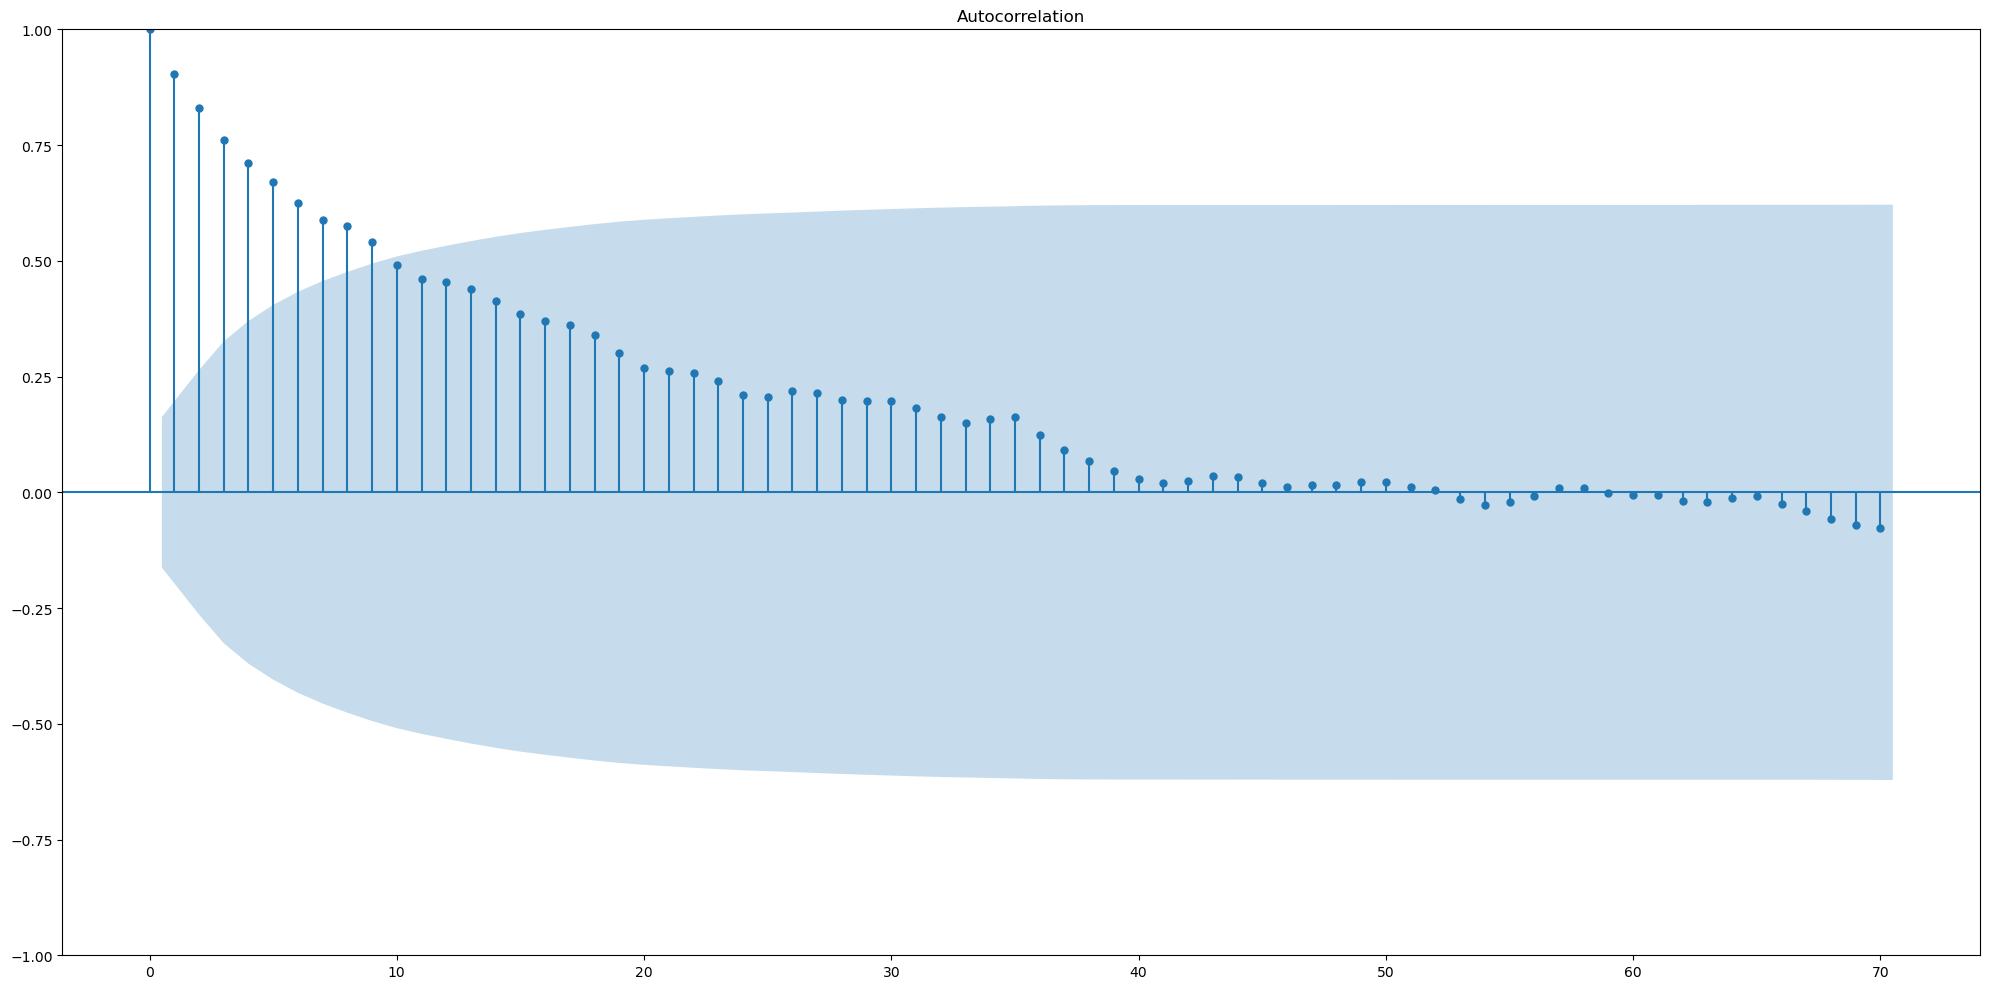

In [16]:
# Calculate the ACF (via statsmodel)
# Source: https://www.alpharithms.com/autocorrelation-time-series-python-432909/

fig = plot_acf(thai_week, lags=70)
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

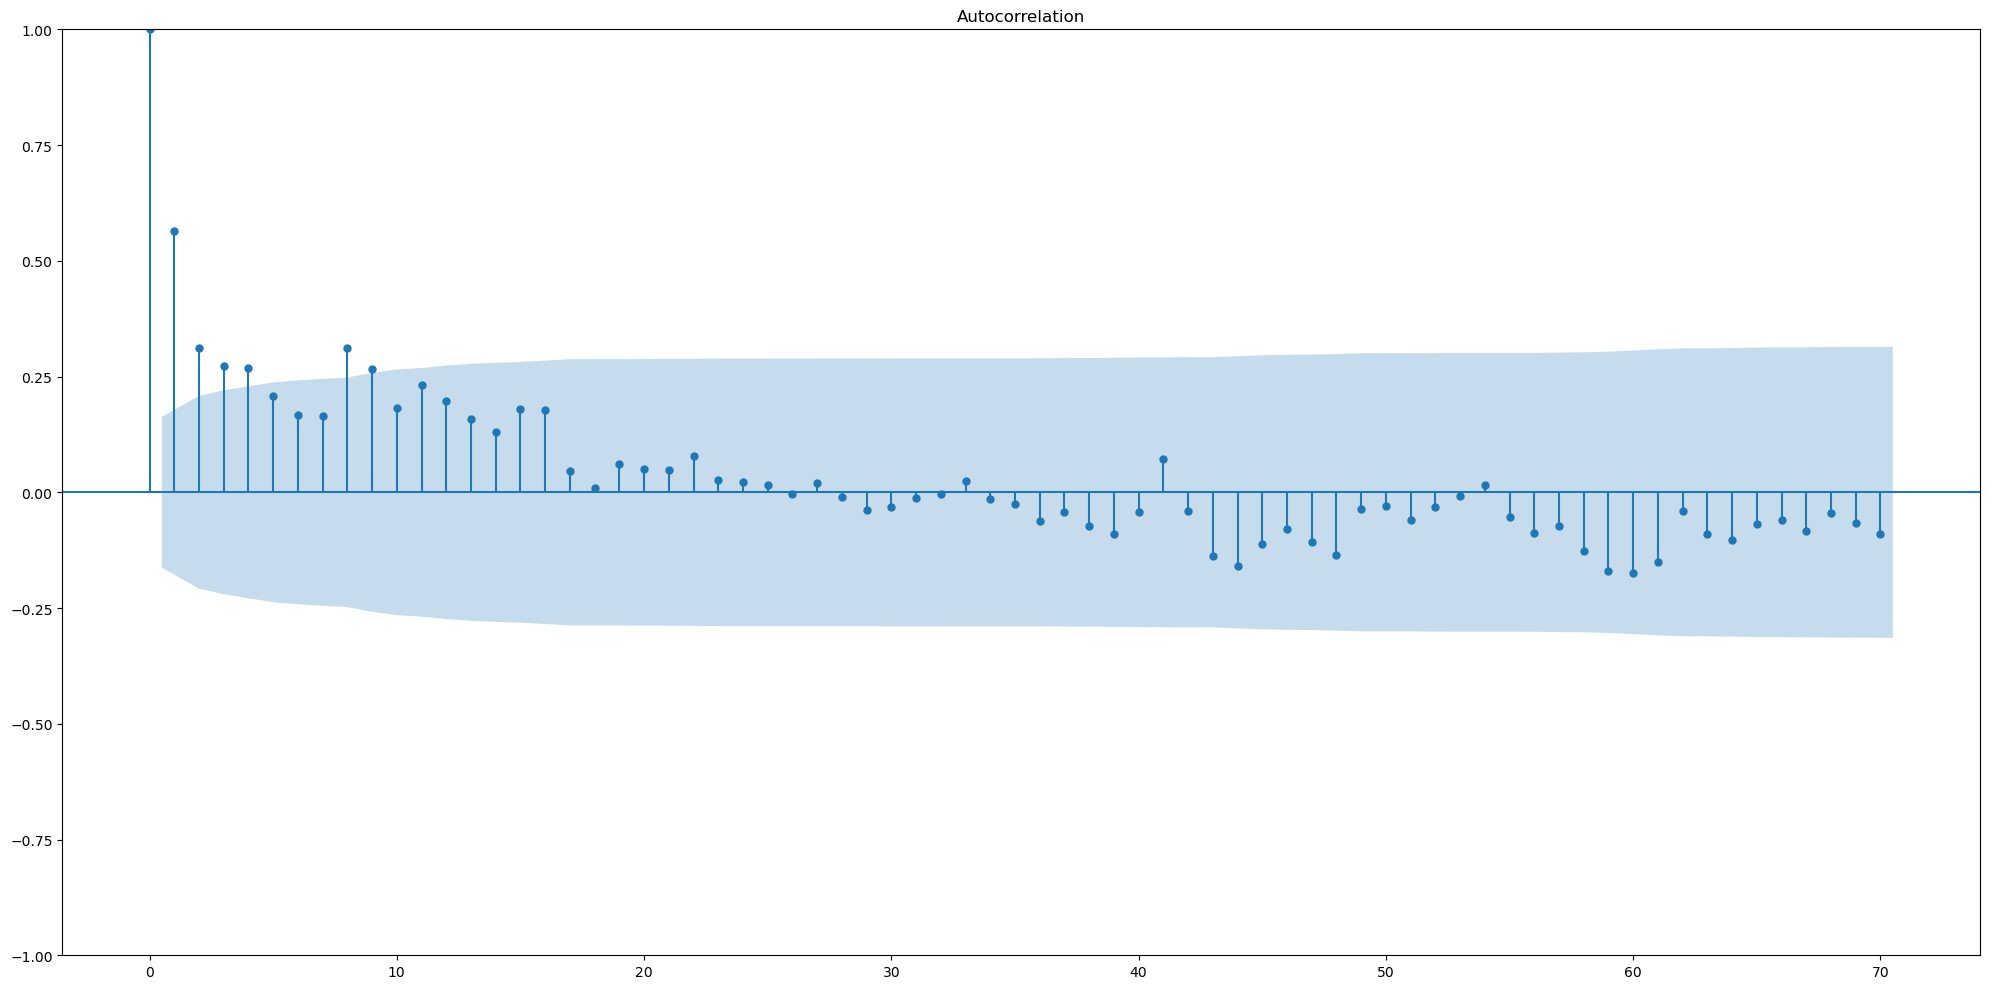

In [17]:
# Calculate the ACF (via statsmodel)
# Source: https://www.alpharithms.com/autocorrelation-time-series-python-432909/

fig = plot_acf(indian_week, lags=70)
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

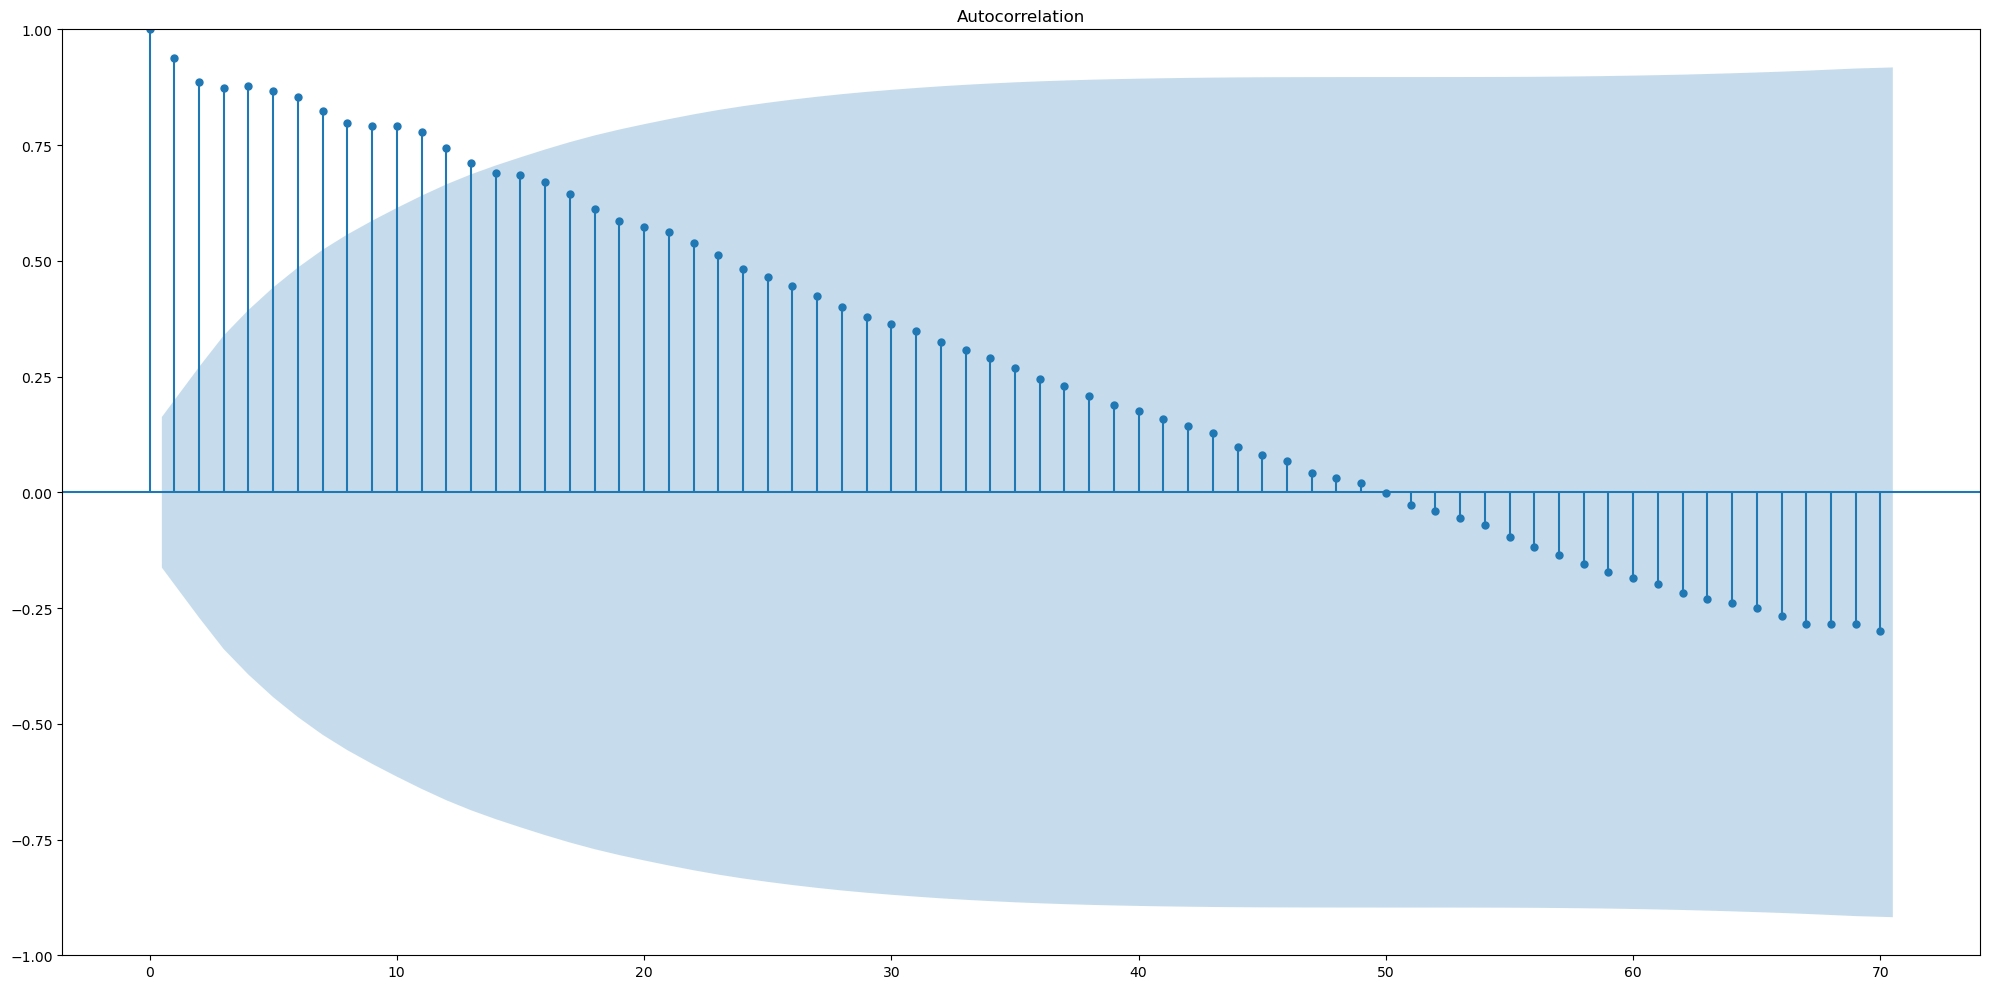

In [18]:
# Calculate the ACF (via statsmodel)
# Source: https://www.alpharithms.com/autocorrelation-time-series-python-432909/

fig = plot_acf(cont_week, lags=70)
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

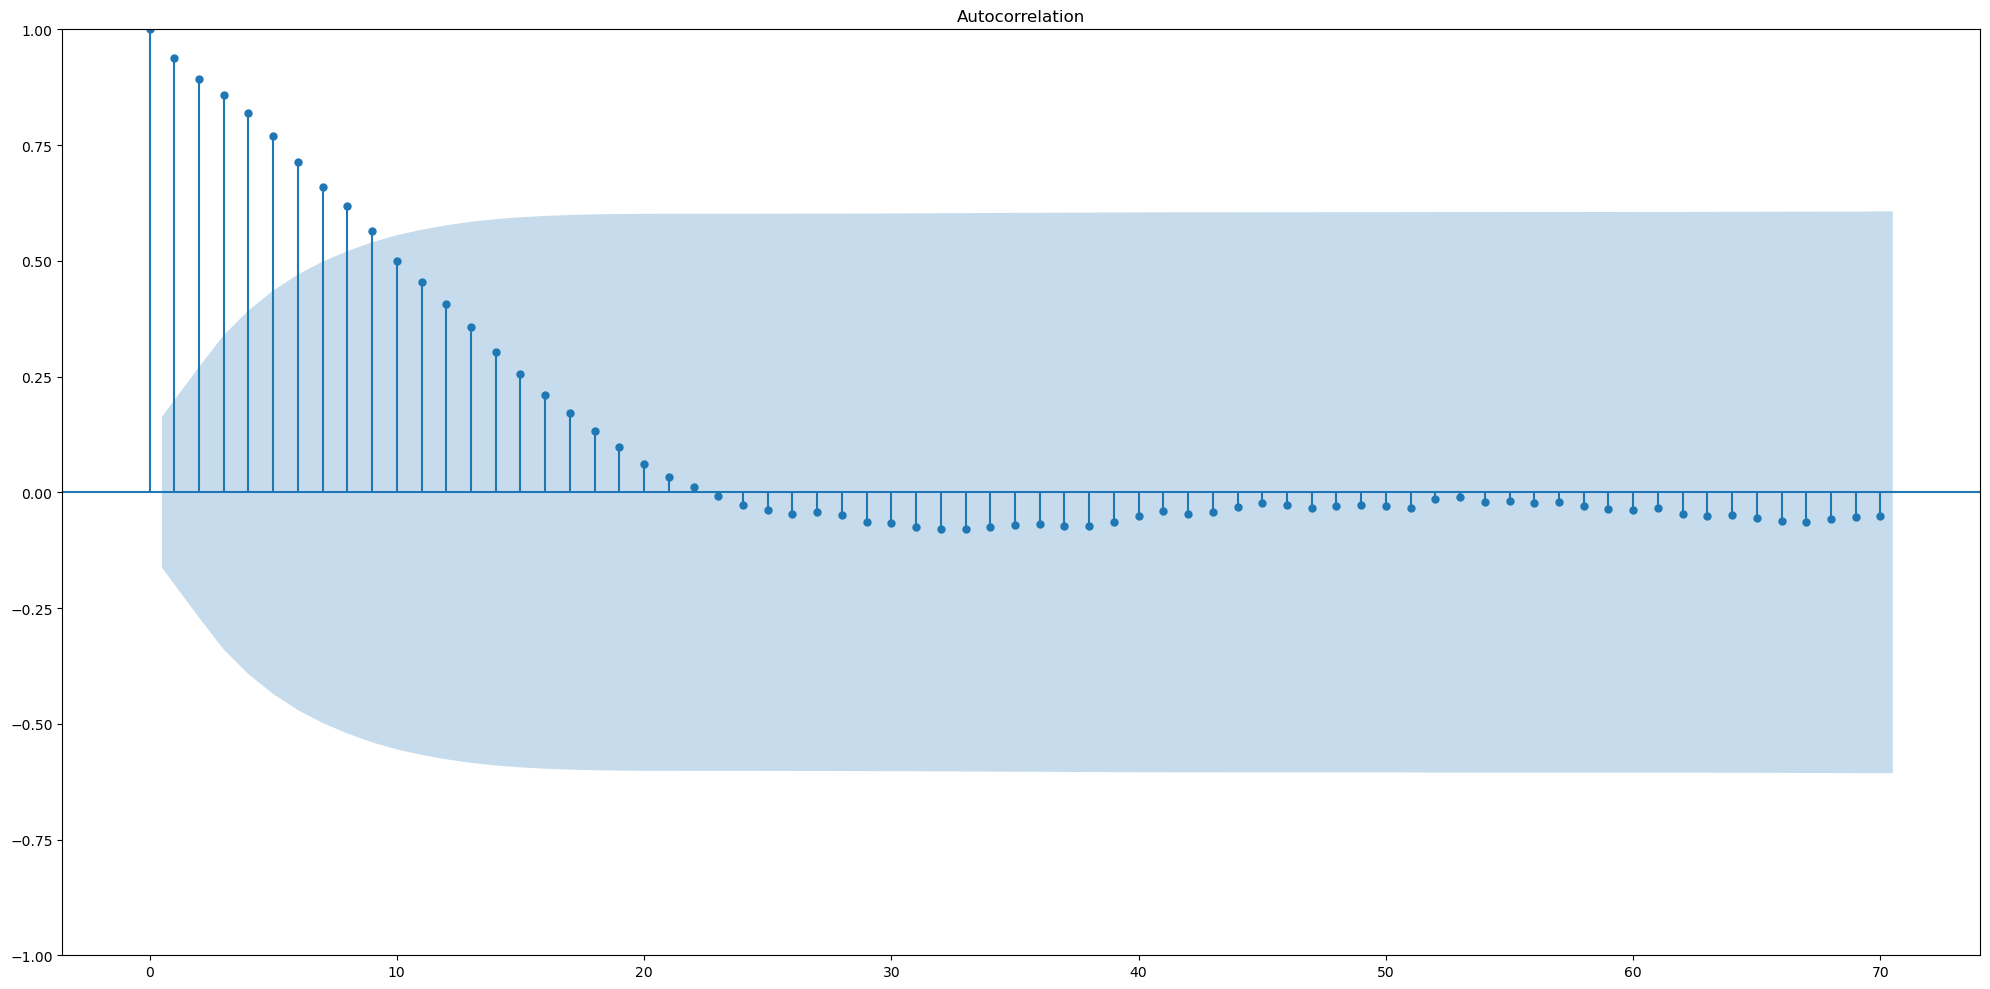

In [19]:
# Calculate the ACF (via statsmodel)
# Source: https://www.alpharithms.com/autocorrelation-time-series-python-432909/

fig = plot_acf(italian_week, lags=70)
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

None of the above ACF plots shows strong seasonality only trends.

In [20]:
top_cont = df[df['cuisine'] == 'Continental'].groupby('category').num_orders.sum()
top_cont

category
Beverages    5943046
Fish          871959
Pizza        7383720
Seafood      2715714
Name: num_orders, dtype: int64

Price difference detrends the data.

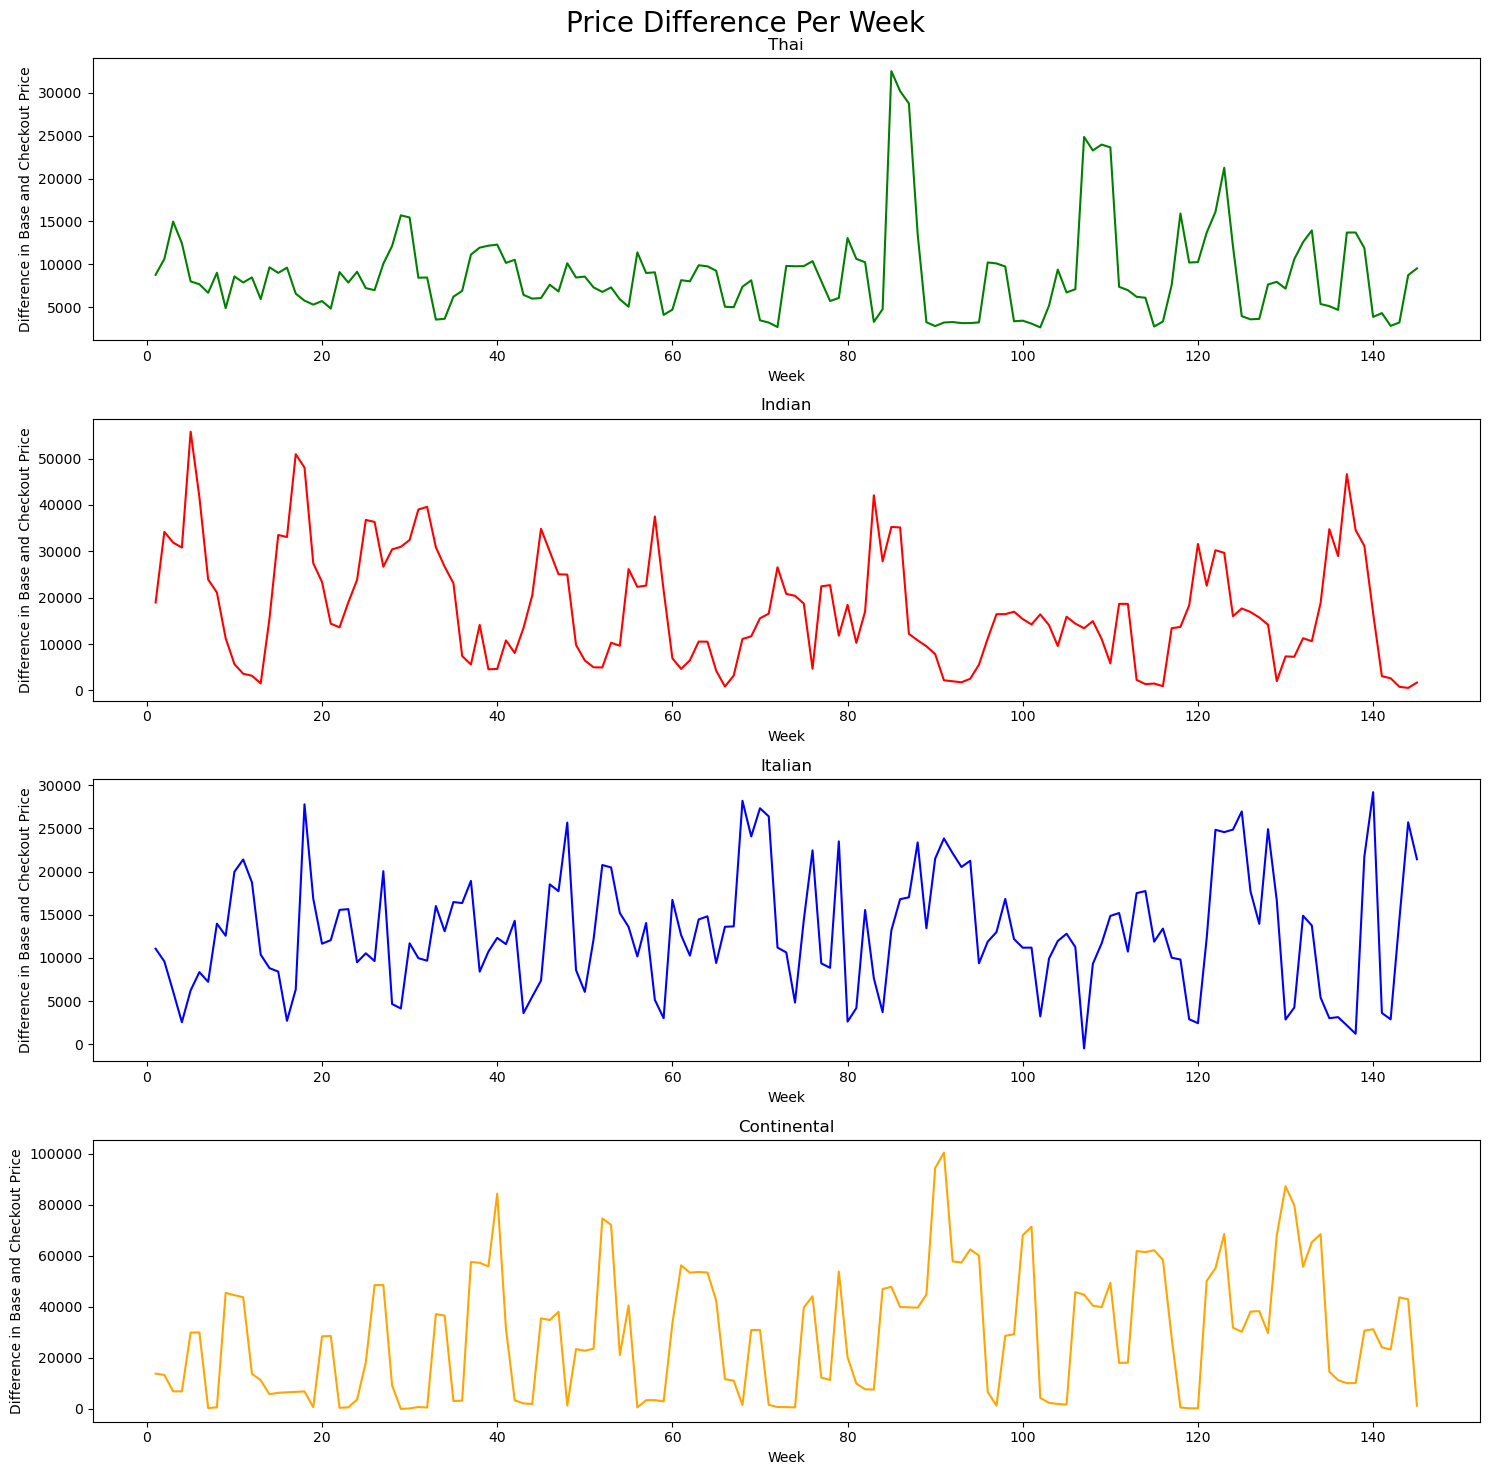

In [21]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (15,15))
subs = [ax1, ax2, ax3, ax4]
color = ['green', 'red', 'blue', 'orange']
for typ, sub, col in zip(list(df['cuisine'].unique()), subs, color):
    weekwise = df[df['cuisine'] == typ].groupby('week').base_price.sum() - df[df['cuisine'] == typ].groupby('week').checkout_price.sum()
    sub.plot(weekwise, color = col)
    sub.set_title(typ)
    sub.set_xlabel('Week')
    sub.set_ylabel('Difference in Base and Checkout Price')
   
fig.suptitle('Price Difference Per Week', fontsize = 20)
fig.subplots_adjust(top=0.90)
plt.xlabel('Week')
fig.tight_layout()
plt.show()

In [22]:
top6 = df.groupby('category').num_orders.sum()
top6

category
Beverages       40480525
Biryani           631848
Desert           1940754
Extras           3984979
Fish              871959
Other Snacks     4766293
Pasta            1637744
Pizza            7383720
Rice Bowl       20874063
Salad           10944336
Sandwich        17636782
Seafood          2715714
Soup             1039646
Starters         4649122
Name: num_orders, dtype: int64

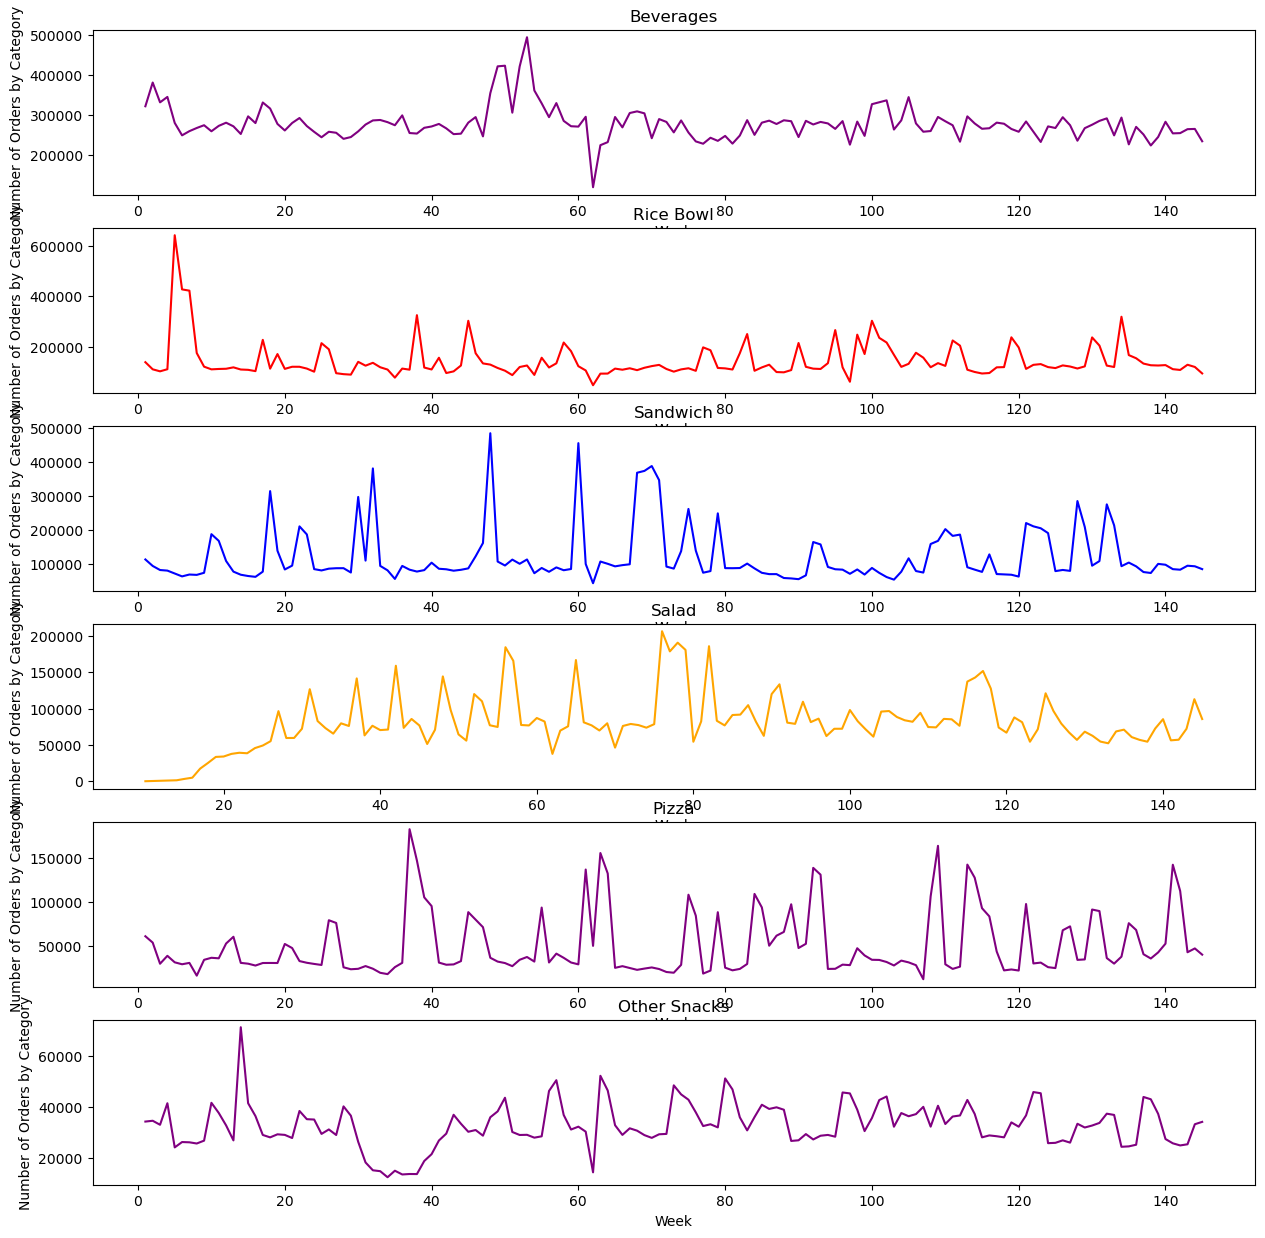

In [23]:
ig, (ax1, ax2, ax3,ax4, ax5,ax6) = plt.subplots(6, figsize = (15,15))
top6 = ['Beverages', 'Rice Bowl', 'Sandwich', 'Salad', 'Pizza', 'Other Snacks']
color = ['purple', 'red', 'blue', 'orange','purple', 'purple']
subs = [ax1,ax2,ax3,ax4,ax5,ax6]
for typ, sub, col in zip(top6, subs, color):
    weekwise = df[df['category'] == typ].groupby('week').num_orders.sum() 
    sub.plot(weekwise, color = col)
    sub.set_title(typ)
    sub.set_xlabel('Week')
    sub.set_ylabel('Number of Orders by Category')
   
fig.suptitle('Orders Per Week: Top 6', fontsize = 20)
fig.subplots_adjust(top=0.90)
plt.xlabel('Week')
fig.tight_layout()
plt.show()

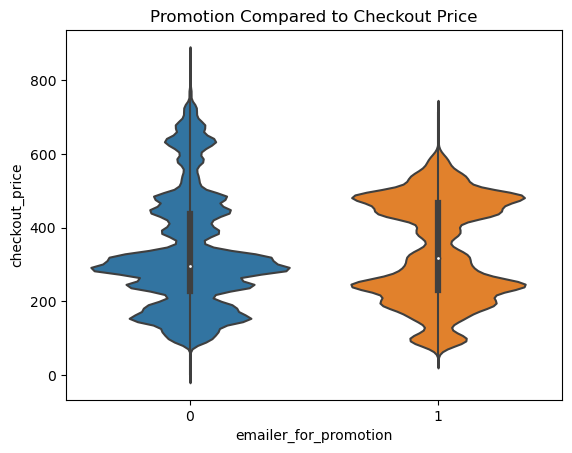

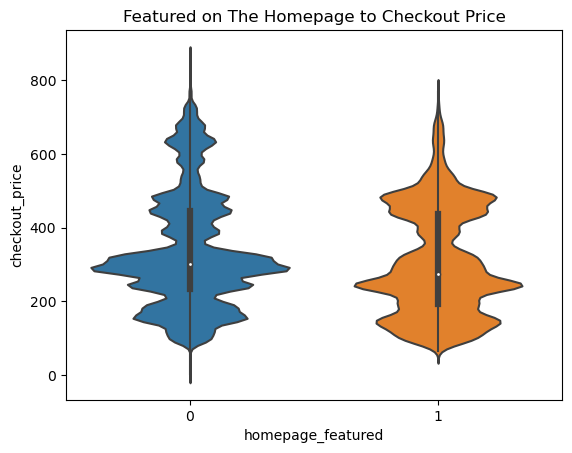

In [24]:
plt.clf()
sns.violinplot(data=df, x='emailer_for_promotion', y= 'checkout_price')
plt.title('Promotion Compared to Checkout Price')

plt.show()
sns.violinplot(data=df, x='homepage_featured', y= 'checkout_price')
plt.title('Featured on The Homepage to Checkout Price')
plt.show()

In [25]:
norm_df = df
norm_df

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1018704,2,55,1885,135.83,152.29,0,0,323,Beverages,Thai,647,56,TYPE_C,2.0
2,1196273,3,55,1885,132.92,133.92,0,0,96,Beverages,Thai,647,56,TYPE_C,2.0
3,1116527,4,55,1885,135.86,134.86,0,0,163,Beverages,Thai,647,56,TYPE_C,2.0
4,1343872,5,55,1885,146.50,147.50,0,0,215,Beverages,Thai,647,56,TYPE_C,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1437396,141,61,2104,583.03,630.53,0,1,13,Fish,Continental,473,77,TYPE_A,4.5
456544,1060716,142,61,2104,581.03,582.03,0,0,42,Fish,Continental,473,77,TYPE_A,4.5
456545,1029231,143,61,2104,583.03,581.03,0,0,40,Fish,Continental,473,77,TYPE_A,4.5
456546,1141147,144,61,2104,582.03,581.03,0,0,53,Fish,Continental,473,77,TYPE_A,4.5


In [26]:
norm_df['log_check'] = np.log(df['checkout_price'])
norm_df['log_base'] = np.log(df['base_price'])
norm_df

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area,log_check,log_base
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0,4.918739,5.025787
1,1018704,2,55,1885,135.83,152.29,0,0,323,Beverages,Thai,647,56,TYPE_C,2.0,4.911404,5.025787
2,1196273,3,55,1885,132.92,133.92,0,0,96,Beverages,Thai,647,56,TYPE_C,2.0,4.889747,4.897243
3,1116527,4,55,1885,135.86,134.86,0,0,163,Beverages,Thai,647,56,TYPE_C,2.0,4.911625,4.904237
4,1343872,5,55,1885,146.50,147.50,0,0,215,Beverages,Thai,647,56,TYPE_C,2.0,4.987025,4.993828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1437396,141,61,2104,583.03,630.53,0,1,13,Fish,Continental,473,77,TYPE_A,4.5,6.368239,6.446561
456544,1060716,142,61,2104,581.03,582.03,0,0,42,Fish,Continental,473,77,TYPE_A,4.5,6.364802,6.366522
456545,1029231,143,61,2104,583.03,581.03,0,0,40,Fish,Continental,473,77,TYPE_A,4.5,6.368239,6.364802
456546,1141147,144,61,2104,582.03,581.03,0,0,53,Fish,Continental,473,77,TYPE_A,4.5,6.366522,6.364802


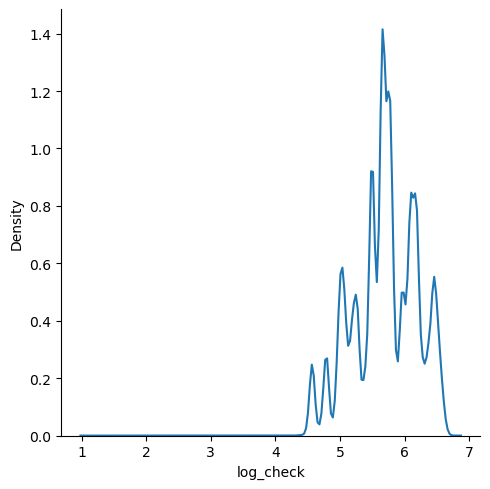

In [27]:
sns.displot(data=norm_df, x='log_check', kind='kde')
plt.show()

In [28]:
meal_group_week = df[df['meal_id'] == 2104].groupby('week').num_orders.sum()

<AxesSubplot: xlabel='week'>

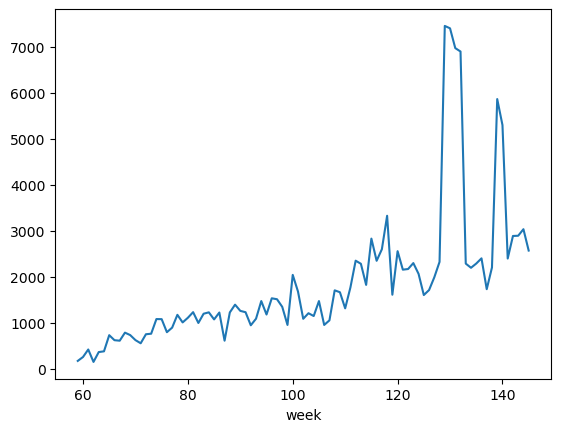

In [29]:
meal_group_week.plot()

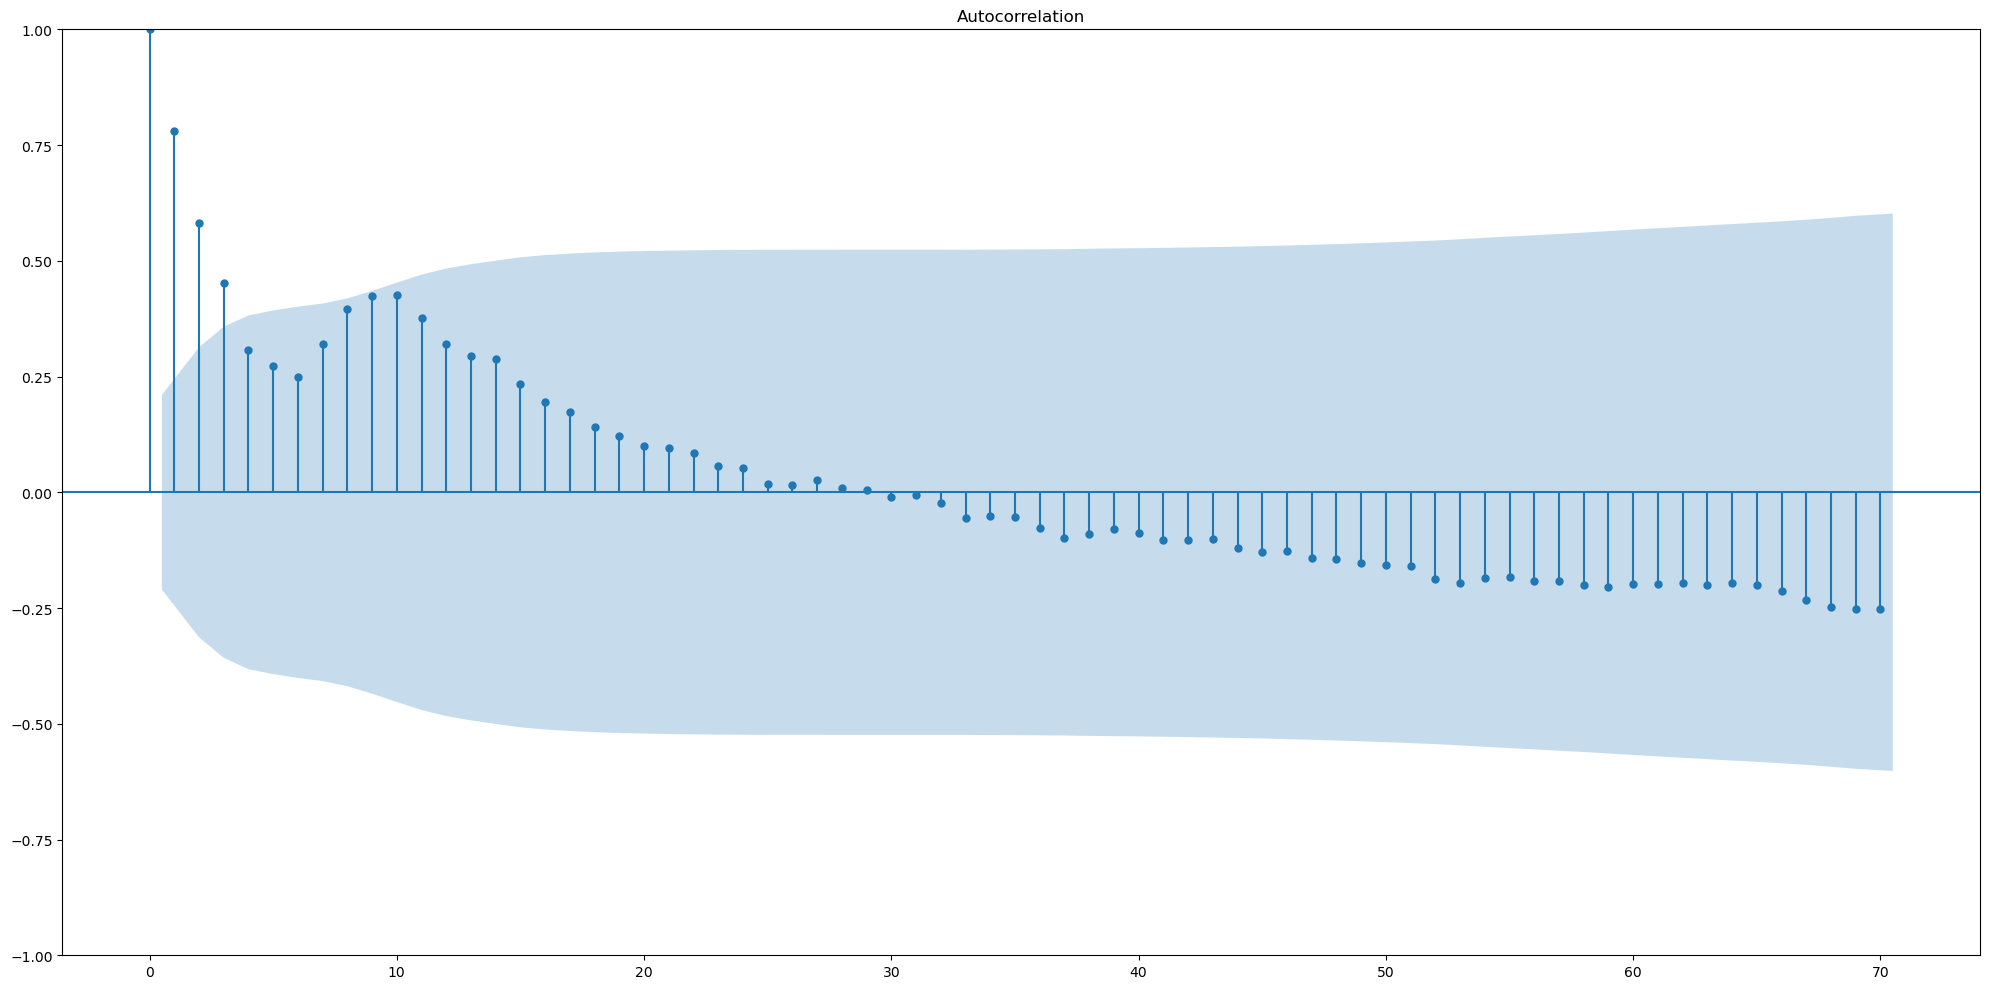

In [30]:
# Calculate the ACF (via statsmodel)
# Source: https://www.alpharithms.com/autocorrelation-time-series-python-432909/

fig = plot_acf(meal_group_week, lags=70)
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

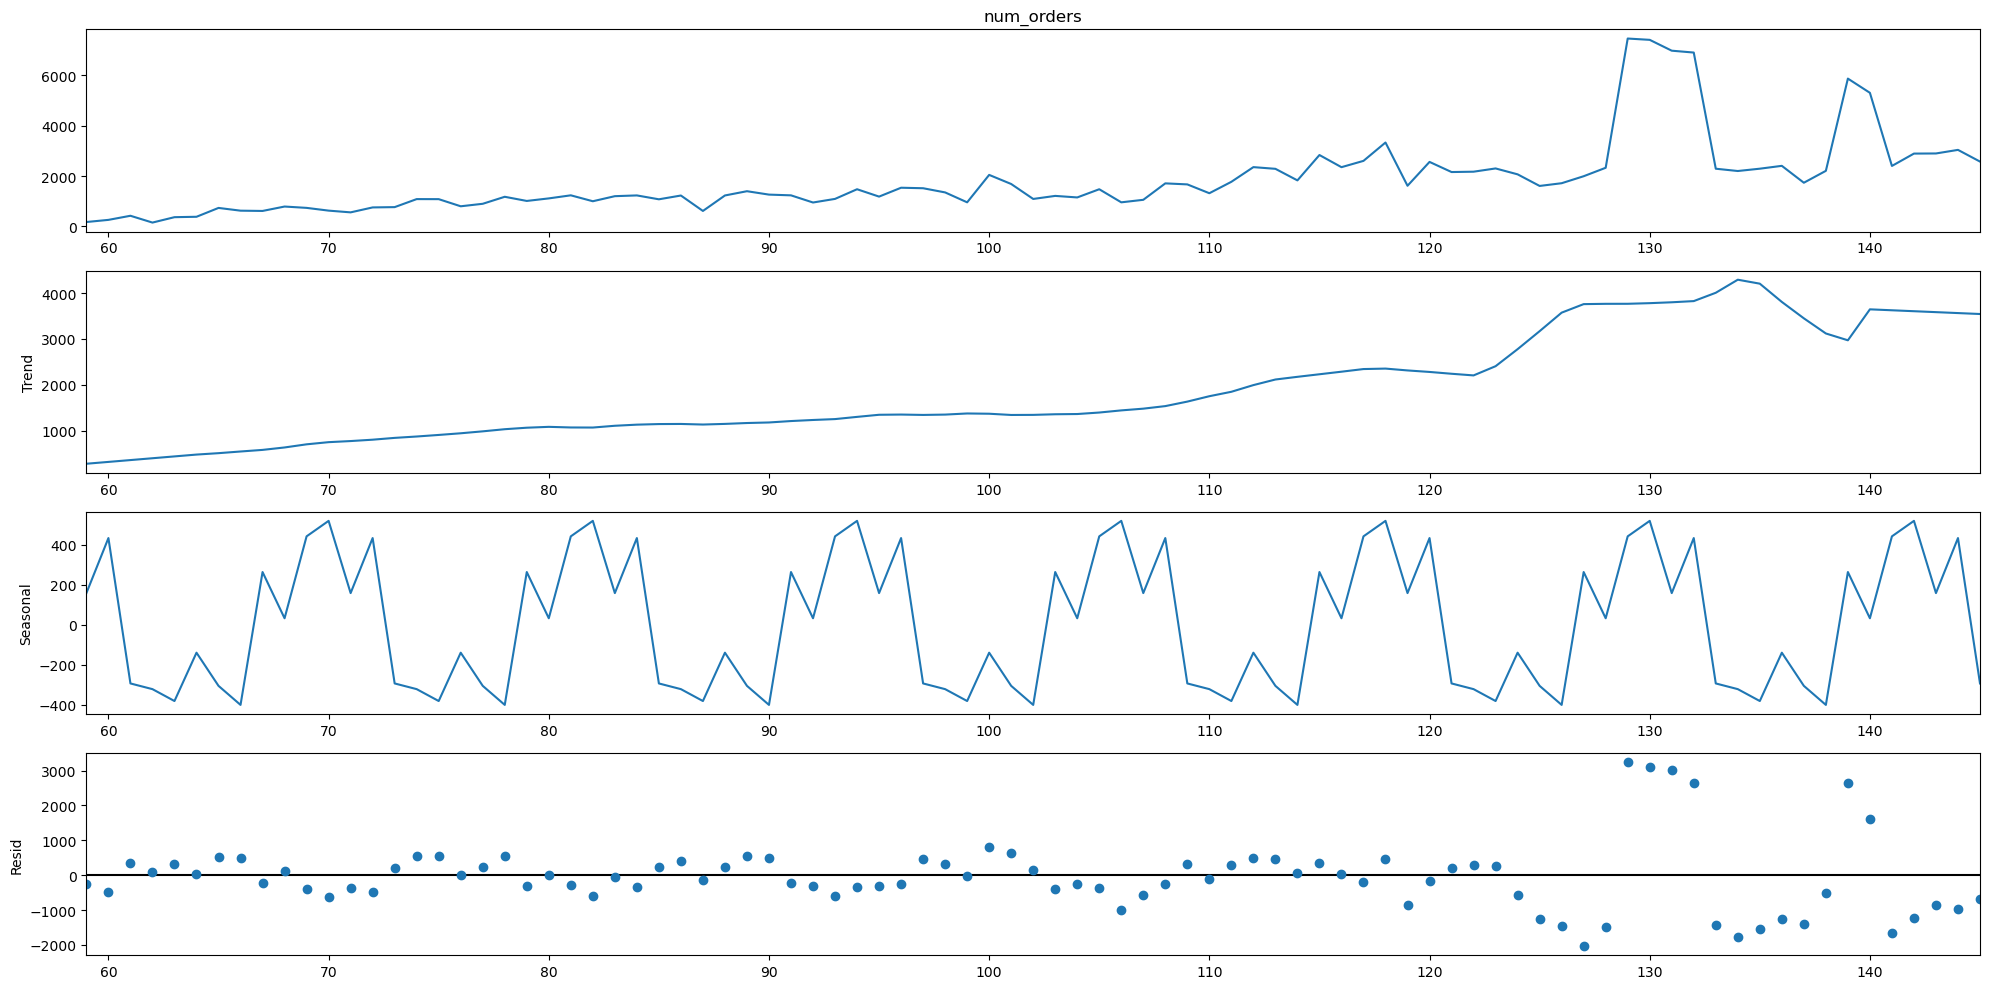

In [31]:
res = sm.tsa.seasonal_decompose(meal_group_week, period=12, extrapolate_trend='freq')
fig = res.plot()
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [32]:
# extract the decomposed terms
meal_group_week['trend'] = res.trend
meal_group_week['seasonal'] = res.seasonal
meal_group_week['error'] = res.resid
meal_group_week

week
59                                                        176
60                                                        261
61                                                        424
62                                                        154
63                                                        368
                                  ...                        
144                                                      3037
145                                                      2573
trend       week
59      276.670746
60      316.693036
61 ...
seasonal    week
59     157.826371
60     433.061912
61   ...
error       week
59     -258.497117
60     -488.754948
61 ...
Name: num_orders, Length: 90, dtype: object

<AxesSubplot: >

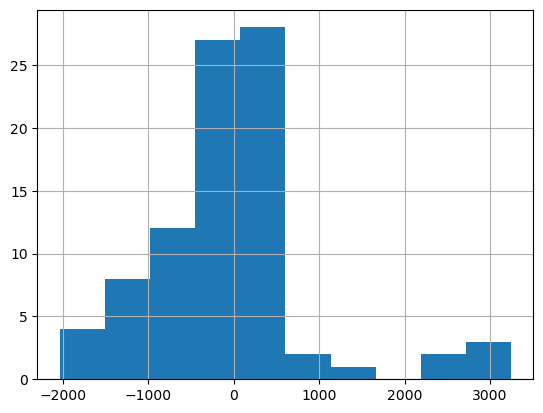

In [33]:
meal_group_week['error'].hist()

In [34]:
meal_group_week1 = df[df['meal_id'] == 1885].groupby('week').num_orders.sum()
meal_group_week2 = df[df['meal_id'] == 2104].groupby('week').num_orders.sum()

In [35]:
differenced1 = meal_group_week1.diff()
differenced2 = meal_group_week2.diff()

In [36]:
differenced1

week
1          NaN
2      10742.0
3      -6852.0
4       2170.0
5      -9057.0
        ...   
141    -5279.0
142      588.0
143     1395.0
144     -678.0
145    -1966.0
Name: num_orders, Length: 145, dtype: float64

<AxesSubplot: xlabel='week'>

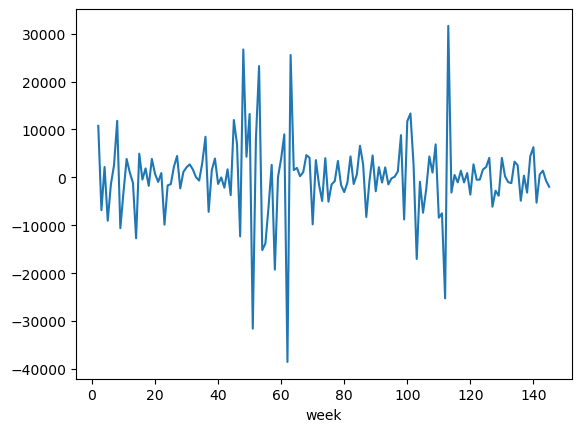

In [37]:
differenced1.plot()

<AxesSubplot: xlabel='week'>

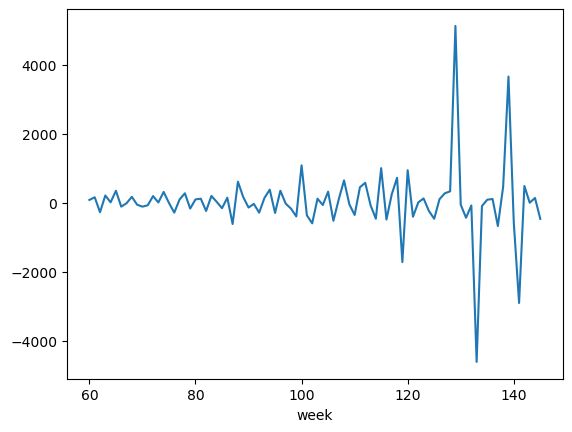

In [38]:
differenced2.plot()

In [39]:
nRowsRead = None # specify 'None' if want to read whole file
# food_Demand_test.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('data/food_Demand_test.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'food_Demand_test.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 32573 rows and 8 columns


In [40]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [41]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [42]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


/var/folders/97/s21rqym901g32vtbzppdcjzc0000gn/T/ipykernel_47893/128494285.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns') # drop columns with NaN


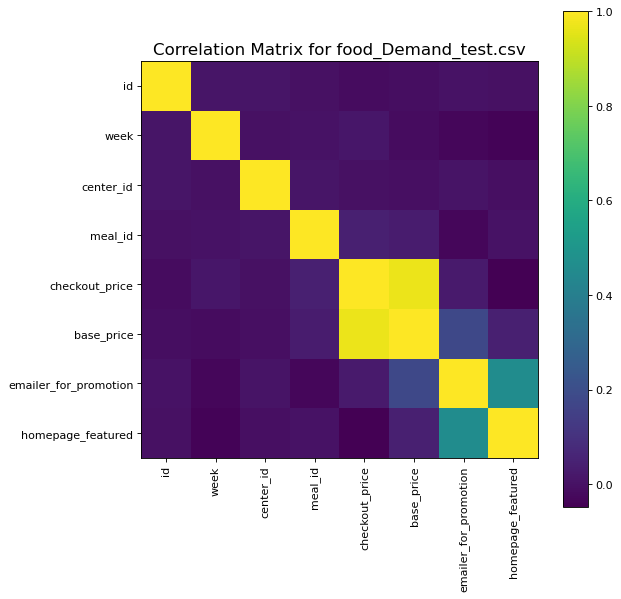

In [43]:
plotCorrelationMatrix(df1, 8)

/var/folders/97/s21rqym901g32vtbzppdcjzc0000gn/T/ipykernel_47893/950191735.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


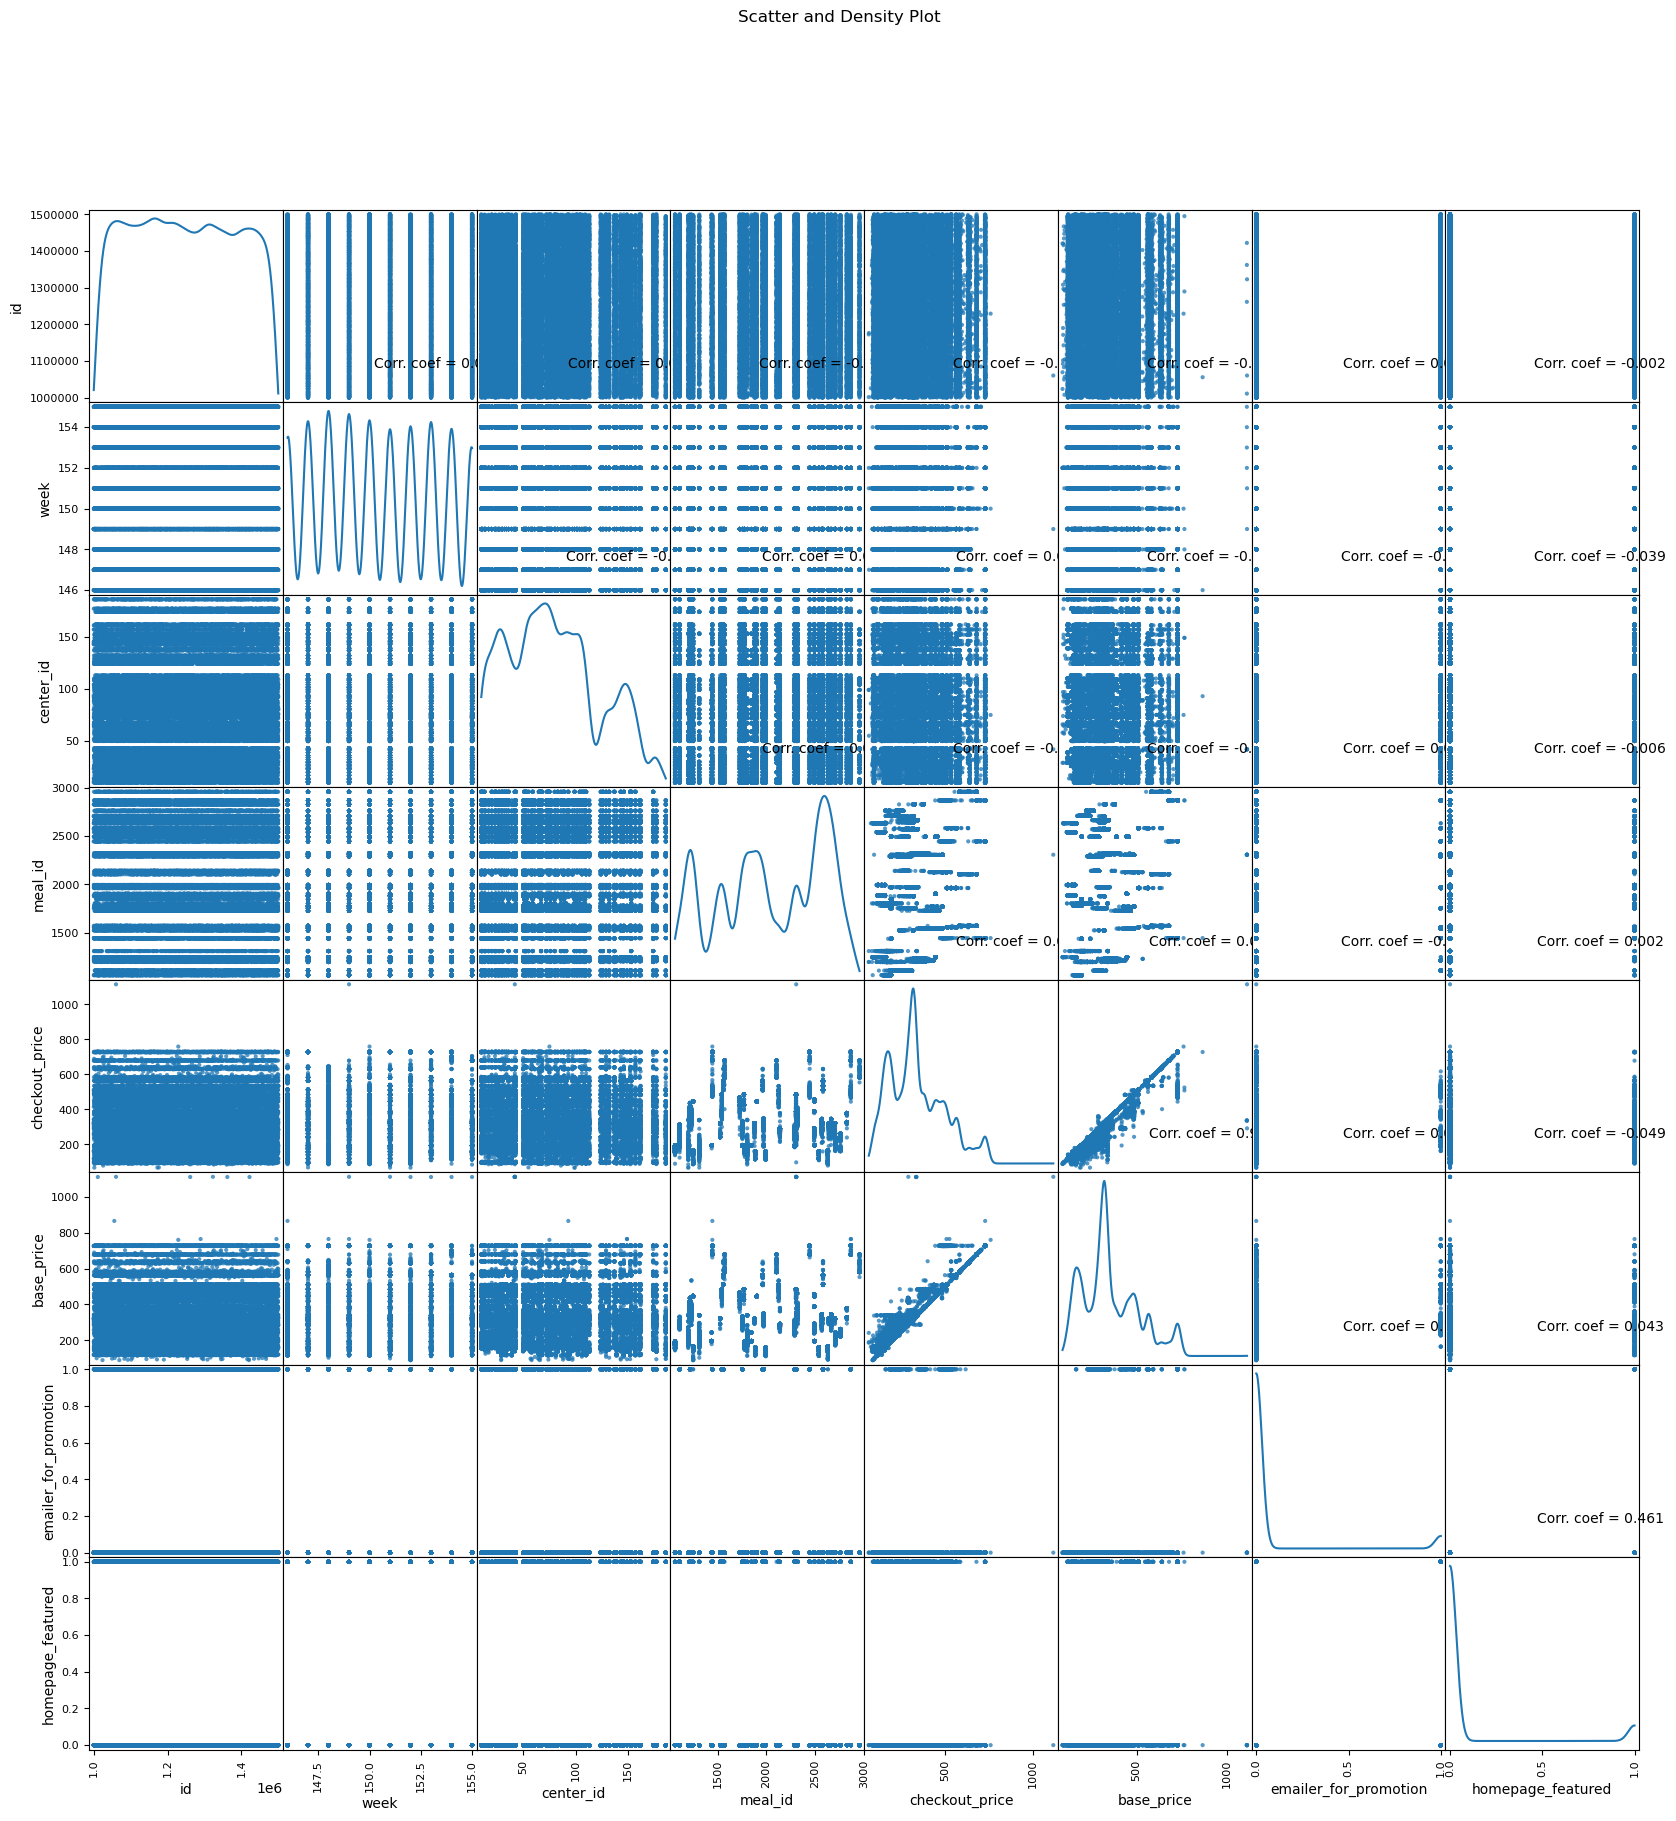

In [44]:
plotScatterMatrix(df1, 20, 10)